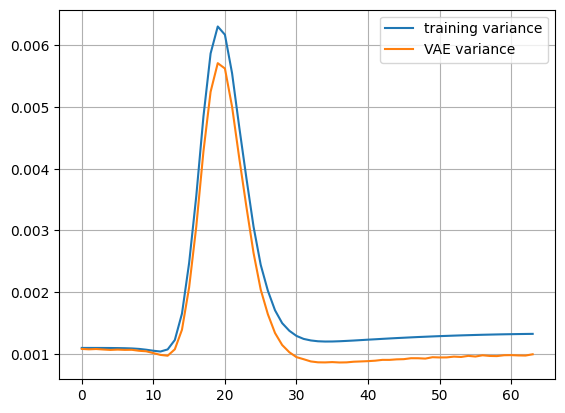

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Grace_Data/


import torch # we need pytorch installed
from models import VAE # import the VAE model
import numpy as np
import matplotlib.pyplot as plt
import pandas
import json

from scipy import stats
import scipy
import datetime
import os

plt.close('all')

#%% SETTINGS
DataType = 'cn'
LatentDim = 5
HiddenDims = [32, 16]
Beta = .0014
BatchSize = 128
Epochs = 3000
IsTest = False # when True, don't save figures or create directory

date = datetime.datetime.now().strftime('%m%d%H%M%S')


# Create parent 'figs' folder if it doesn't exist
#if not os.path.exists('./figs'):
#    os.mkdir('./figs')
#
#dirname = './figs/' + DataType\
#        + '_dim' + str(LatentDim) + '_'
#for i, d in enumerate(HiddenDims):
#    dirname += str(HiddenDims[i])
#    if i < len(HiddenDims) - 1:
#        dirname += 'x'
#dirname += '_beta' + str(Beta)\
#        + '_batch' + str(BatchSize)\
#        + '_epochs' + str(Epochs)\
#        + '_' + date

## Then create the specific subfolder
#if not IsTest:
#    os.mkdir(dirname)
#print(dirname)
#
#if IsTest:
#    print('TEST----TEST----TEST')
#else:
#    os.mkdir(dirname)
#print(dirname)



# set device
Dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# load training data
json_file = './neptune_GMVAE_training_5000_data_scaled_downsampled.json'

# Load the JSON file
with open(json_file, 'r') as f:
    dataset = json.load(f)

# dataset is a dict: sample0, sample1, etc.
# Collect vel arrays where label == 1
filtered_data = [entry['vel'] for entry in dataset.values() if entry['label'] == 1]

# Convert to numpy array
data = np.array(filtered_data)

n_data, k_data = data.shape # define number of samples and features

x_trn = torch.from_numpy(data).type(torch.FloatTensor).to(Dev)
x_trn_cpu = x_trn.cpu()

print('Loaded {} samples with label 1.'.format(len(filtered_data)))
print('total loss function calls: ', len(data)/BatchSize*Epochs)


# draw the training data
fig, ax = plt.subplots()
ax.grid()
ax.set_title('training data')
ax.set_xlabel('x')
ax.set_ylabel('velocity')

for i in range(min(100, len(filtered_data))):
    ax.plot(x_trn_cpu[i])

#if not IsTest:
#    plt.savefig(dirname + '/trainingData.png')


#%% train
vae_model = VAE(k_data,
                latent_dim = LatentDim, # define the latent dimension of the auto-encoder
                hidden_dims = HiddenDims, # define the strucute of the encoder and decoder
                beta = Beta,
                dev = Dev
               )
vae_model.to(Dev)
epoch_loss, rec_loss, kld_loss = vae_model.train(x_trn,
                                                 batch_size = BatchSize,
                                                 epochs = Epochs
                                                 ) # train the vae model using synthetic data


#%% plots
# total loss
fig, ax = plt.subplots()
ax.grid()
ax.plot(epoch_loss, '.')
ax.set_ylim(-1, 30)

#if not IsTest:
#    plt.savefig(dirname + '/loss.png')

# loss sources
fig, ax = plt.subplots()
ax.grid()
ax.plot(rec_loss, '.', label = 'reconstruction')
ax.plot(kld_loss, '.', label = 'kld')
ax.legend()

#if not IsTest:
#    plt.savefig(dirname + '/losses.png')

# reconstruction error
tind = 10
x = x_trn_cpu[tind]
x_hat = vae_model.generate(x_trn[tind]).cpu()
fig, ax = plt.subplots()
ax.grid()

ax.plot(x, label = 'x')
ax.plot(x_hat.detach(), label = 'x_hat')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('rho')

#if not IsTest:
#    plt.savefig(dirname + '/reconstruction.png')

# synthetic data
new_samp = vae_model.sample(num_samples = 100).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.set_title('synthetic data')
#ax.set_xlim(-1.1, 2.2)
ax.set_xlabel('x')
ax.set_ylabel('rho')


for i in range(100):
    ax.plot(new_samp[i].detach())
#if not IsTest:
#    plt.savefig(dirname + '/syntheticData.png')

# compare variance
big_samp = vae_model.sample(num_samples = n_data).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.plot(stats.describe(x_trn_cpu, axis = 0)[3], label = 'training variance')
ax.plot(stats.describe(big_samp.detach(), axis = 0)[3], label = 'VAE variance')
ax.legend()

#if not IsTest:
#    plt.savefig(dirname + '/variance.png')


In [ ]:
print(n_data,k_data)

3274 64
